In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./introduction.ipynb'))))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from itertools import product
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures

from ylearn.exp_dataset.exp_data import single_continuous_treatment, single_binary_treatment, multi_continuous_treatment
from ylearn.estimator_model.double_ml import DML4CATE

## Single continuous treatment.
Valid estimation models include
- DoubleML
- DeepIV
- CausalTree

### The dataset is generated by the following process [1]
Below we use the einstein notation to alleviate the headaches of specifiying dimensions of tensors.
\begin{align*}
    x & = \beta_i w^i \\
    y & = x \theta(v^i) + \gamma_j w^j + \epsilon \\
    w & \sim \text{Normal}(0, I_{n_w})\\
    v & \sim \text{Uniform}(0, 1)^{n_v}
\end{align*}

In [3]:
train, val, treatment_effect = single_continuous_treatment()

adjustment = train.columns[:-4]
covariate = 'c_0'
outcome = 'outcome'
treatment = 'treatment'

def exp_te(x): return np.exp(2*x)
dat = np.array(list(product(np.arange(0, 1, 0.01), repeat=1))).ravel()
data_test = pd.DataFrame({'c_0': dat})
true_te = np.array([exp_te(xi) for xi in data_test[covariate]])

In [4]:
adjustment = train.columns[:-4]
covariate = 'c_0'
outcome = 'outcome'
treatment = 'treatment'

In [5]:
dml = DML4CATE(
    x_model=RandomForestRegressor(),
    y_model=RandomForestRegressor(),
    cf_fold=1,
    covariate_transformer = PolynomialFeatures(degree=3,include_bias=False)
)
dml.fit(
    train,
    outcome,
    treatment,
    adjustment,
    covariate, 
)

08-24 14:24:12 I ylearn.e.double_ml.py 686 - _fit_1st_stage: fitting x_model RandomForestRegressor
08-24 14:24:14 I ylearn.e.double_ml.py 691 - _fit_1st_stage: fitting y_model RandomForestRegressor
08-24 14:24:16 I ylearn.e.double_ml.py 716 - _fit_2nd_stage: fitting yx_model LinearRegression


DML4CATE(x_model=RandomForestRegressor(), y_model=RandomForestRegressor(), yx_model=LinearRegression(), covariate_transformer=PolynomialFeatures(degree=3, include_bias=False))

In [6]:
from ylearn.effect_interpreter.ce_interpreter import CEInterpreter

In [7]:
cei = CEInterpreter(max_depth=2,)
cei.fit(data=data_test, est_model=dml)

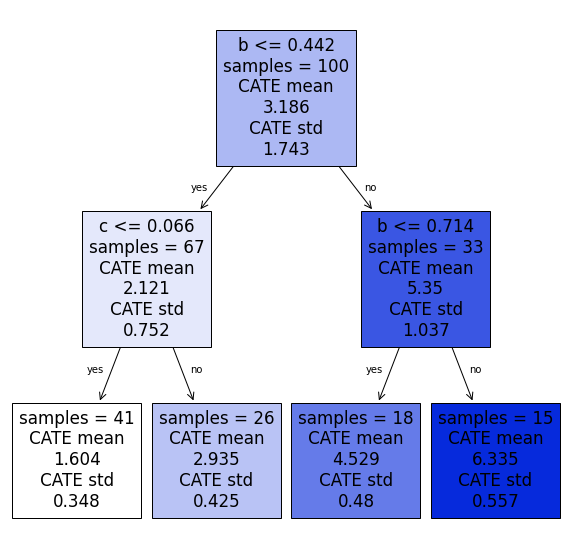

In [8]:
cei.plot(feature_names=['a', 'b', 'c'])
plt.show()

In [9]:
interpret_result = cei.interpret(data=data_test[4:6])

decision node 0: (covariate [0, 1] = 0.0015999999595806003) <= 0.44225001335144043 
decision node 1: (covariate [0, 2] = 6.399999983841553e-05) <= 0.0664605014026165 



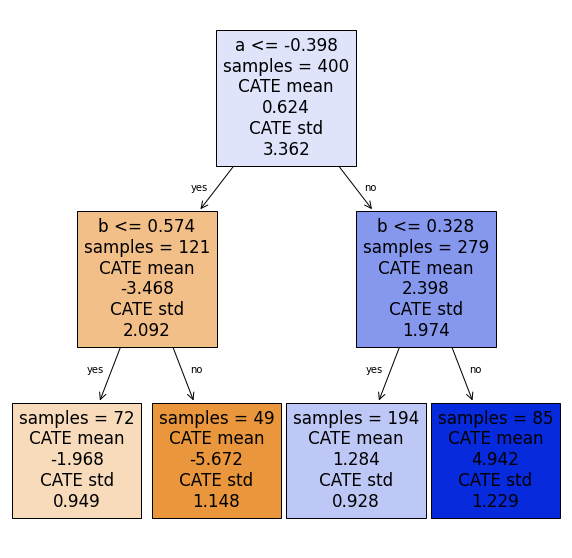

In [14]:
data_test1 = pd.DataFrame({'c_0': np.array(list(product(np.arange(-1, 1, 0.005), repeat=1))).ravel()})
cei1 = CEInterpreter(max_depth=2,)
cei1.fit(data=data_test1, est_model=dml)
cei1.plot(feature_names=['a', 'b', 'c'])
plt.show()